In [1]:
from utils import *

In [2]:
BING_KEY="7cf6aa12ccd044bcbfb974468989c247"
IMAGE_DIR = "images"

In [3]:
categories = 'anime','disney'
path = Path('characters')

In [4]:
if not path.exists():
    path.mkdir()
    for c in categories:
        dest = (path/c)
        dest.mkdir(exist_ok=True)
        results = search_images_bing( BING_KEY,f'{c} character')
        download_images(dest, urls=results.attrgot('content_url'))

In [5]:
fns=get_image_files(path)
failed=verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [26]:
characters= DataBlock(
    blocks =    (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter =  RandomSplitter(valid_pct=0.2,seed=42),
    get_y =     parent_label,
    item_tfms = Resize(128))

In [27]:
#characters = characters.new(item_tfms=Resize(128,ResizeMethod.Pad, pad_mode='zeros'))
#Crop
characters = characters.new(item_tfms=RandomResizedCrop(228,min_scale=.5), batch_tfms=aug_transforms(mult=2))
dls = characters.dataloaders(path)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


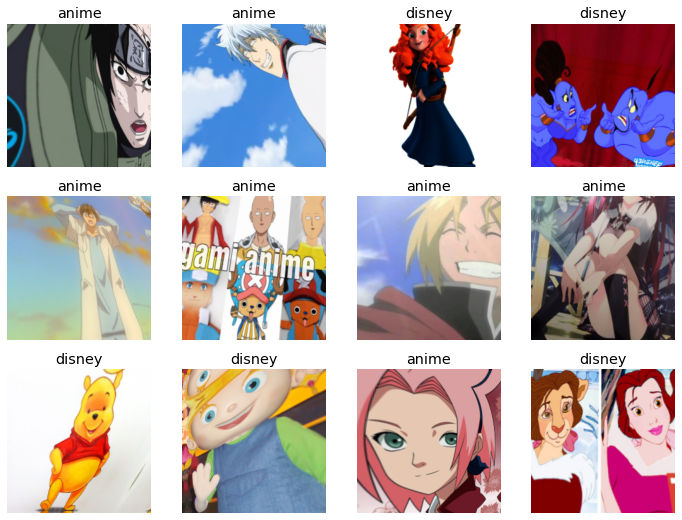

In [28]:
dls.train.show_batch(max_n = 12, nrows = 3)

In [29]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.214647,0.285227,0.157895,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.531157,0.184493,0.105263,00:04
1,0.452667,0.138123,0.052632,00:04
2,0.355021,0.148658,0.035088,00:03
3,0.296367,0.153276,0.035088,00:04


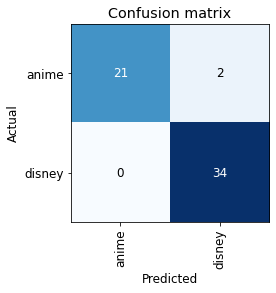

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

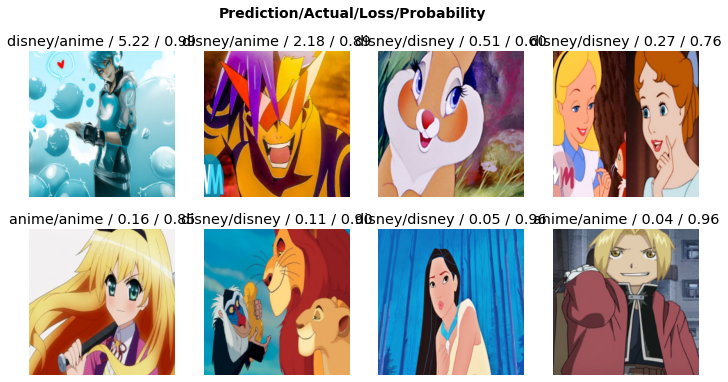

In [31]:
interp.plot_top_losses(8, nrows=2)

In [32]:
from fastai2.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [33]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [34]:
learn.export('characters.pkl')
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('characters.pkl')]

In [15]:
## Try to import and use our model
learn_inf = load_learner('characters.pkl')

In [16]:
learn_inf.predict('characters/disney/00000001.jpg')

('disney', tensor(1), tensor([2.7202e-05, 9.9997e-01]))